# Sensors and Actuators Lab 1: Data Analysis
In order to carry out the points described in the lab, we have to carry out some calculations and plotting, which we have chosen to do in python.

First we import necessary libraries

In [19]:
import pandas as pd # Used for data handling
import numpy as np # Used for calculations
import matplotlib.pyplot as plt # Used to create plots

Then we load the data from excel into a dataframe

The data is split into 4 columns:
- Input Voltage
- Set (which recording it is, where 1 way is 1 set. i.e. going back and forth is 2 sets.)
- Angular Displacement, measured in degrees
- Measured Voltage, given in milivolts

In [20]:
df = pd.read_excel(io="../data/DataInExcel.xlsx", sheet_name="Sheet1")
df

,InputVoltage,Set,Displacment(deg),Voltage(mv)
0,1,1,0,1090.989
1,1,1,10,1090.887
2,1,1,20,1090.046
3,1,1,30,1087.004
4,1,1,40,1079.484
...,...,...,...,...
243,10,6,40,9954.300
244,10,6,30,10024.800
245,10,6,20,10062.000
246,10,6,10,10062.100


Firstly, we create a scatter plot of the data, just to get an idea of how our plot looks. This is done for each of the 3 input voltages.

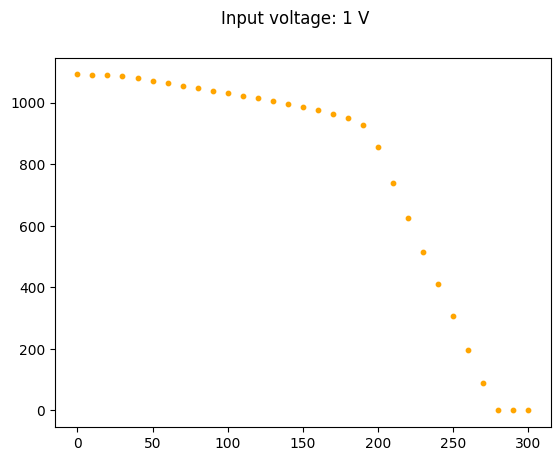

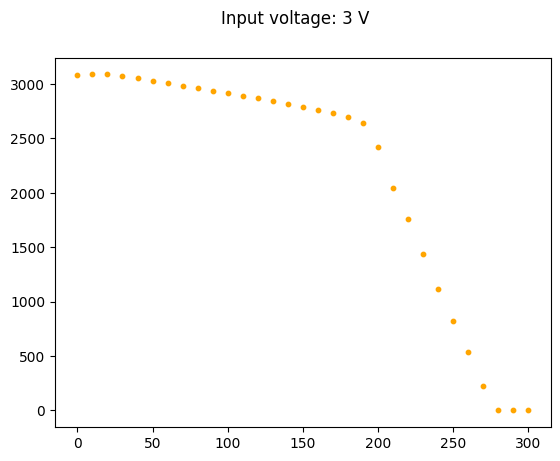

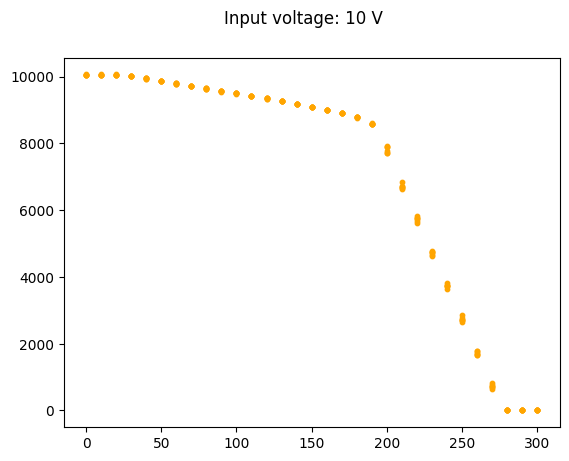

In [21]:
input_voltages = [1, 3, 10]
for input_voltage in input_voltages:
    part_df = df.loc[df['InputVoltage']==input_voltage]
    angular_displacement = part_df['Displacment(deg)'].to_numpy()
    recorded_voltage = part_df['Voltage(mv)'].to_numpy()
    figure = plt.figure()
    plt.scatter(angular_displacement, recorded_voltage, [10], color="#FFA500")
    plt.suptitle(f'Input voltage: {input_voltage} V')

After having the scatter plots, we can make the following conclusions:
**Conclusion 1:**
Between 0-20 degrees, the variation in the values is minimal, and in some cases non-existent

**Conclusion 2:**
Between 280-300 degrees, the same issue as above occur as the get a voltage in 0.XX mV, with almost no variations

**Conclusion 3:**
Between 20-190 degrees, there is a linear decline, that has a readable difference. Meaning one could use it
within this range, which would allow the potentiometer to act as an angular displacement sensor with a range of
180 degrees.

**Conclusion 4:**
Between 190-280 degrees, there is also a linear segment, that has a very readable difference, which would allow
for more noticeable change in voltage per degree, which would allow the potentiometer to act as an angular
displacement sensor with a range of 90 degrees.


## Ideal Straight Line
We now split the data up into 4 parts, where the points at 0, 10, 290, 300 degrees is left out. We will then
look at the data in 2 parts:
- 20-190 degrees
- 190-280 degrees


First 20-190 Degrees:

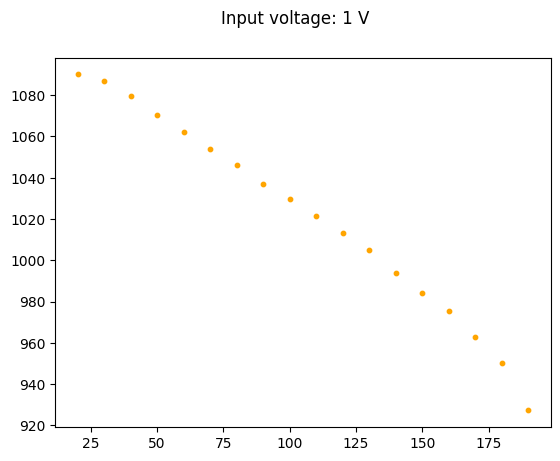

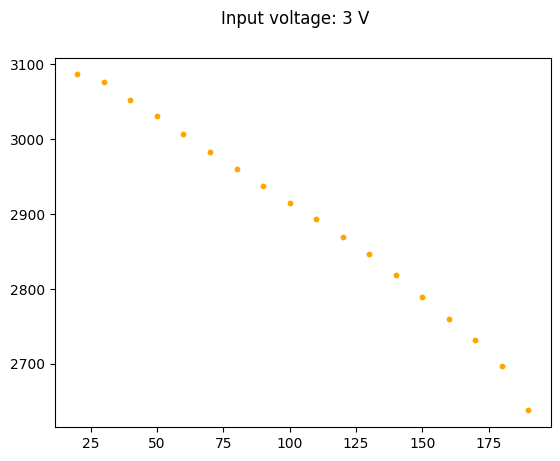

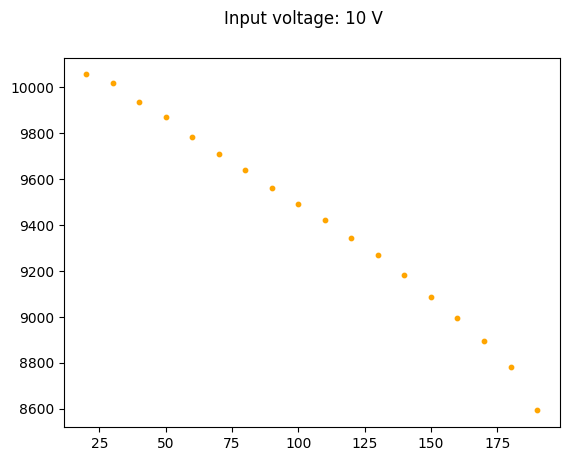

In [25]:
input_voltages = [1, 3, 10]
df_v1 = {}
df_v3 = {}
df_v10 = {}
for input_voltage in input_voltages:
    part_df = df.loc[df['InputVoltage']==input_voltage]
    angular_displacement = part_df['Displacment(deg)'].to_numpy()
    recorded_voltage = part_df['Voltage(mv)'].to_numpy()
    angular_displacement = angular_displacement[2:20]
    recorded_voltage = recorded_voltage[2:20]

    if input_voltage == 1:
        df_v1["Recorded Value (V)"] = recorded_voltage
        df_v1["Angular Displacement"] = angular_displacement
    elif input_voltage == 3:
        df_v3["Recorded Value (V)"] = recorded_voltage
        df_v3["Angular Displacement"] = angular_displacement
    else:
        df_v10["Recorded Value (V)"] = recorded_voltage
        df_v10["Angular Displacement"] = angular_displacement

    figure = plt.figure()
    plt.scatter(angular_displacement, recorded_voltage, [10], color="#FFA500")
    plt.suptitle(f'Input voltage: {input_voltage} V')

We can then create the sensitivity factor of the ideal straight line using the formula:
$K = \frac{O_{max}-O_{min}}{I_{max}-I_{min}}$

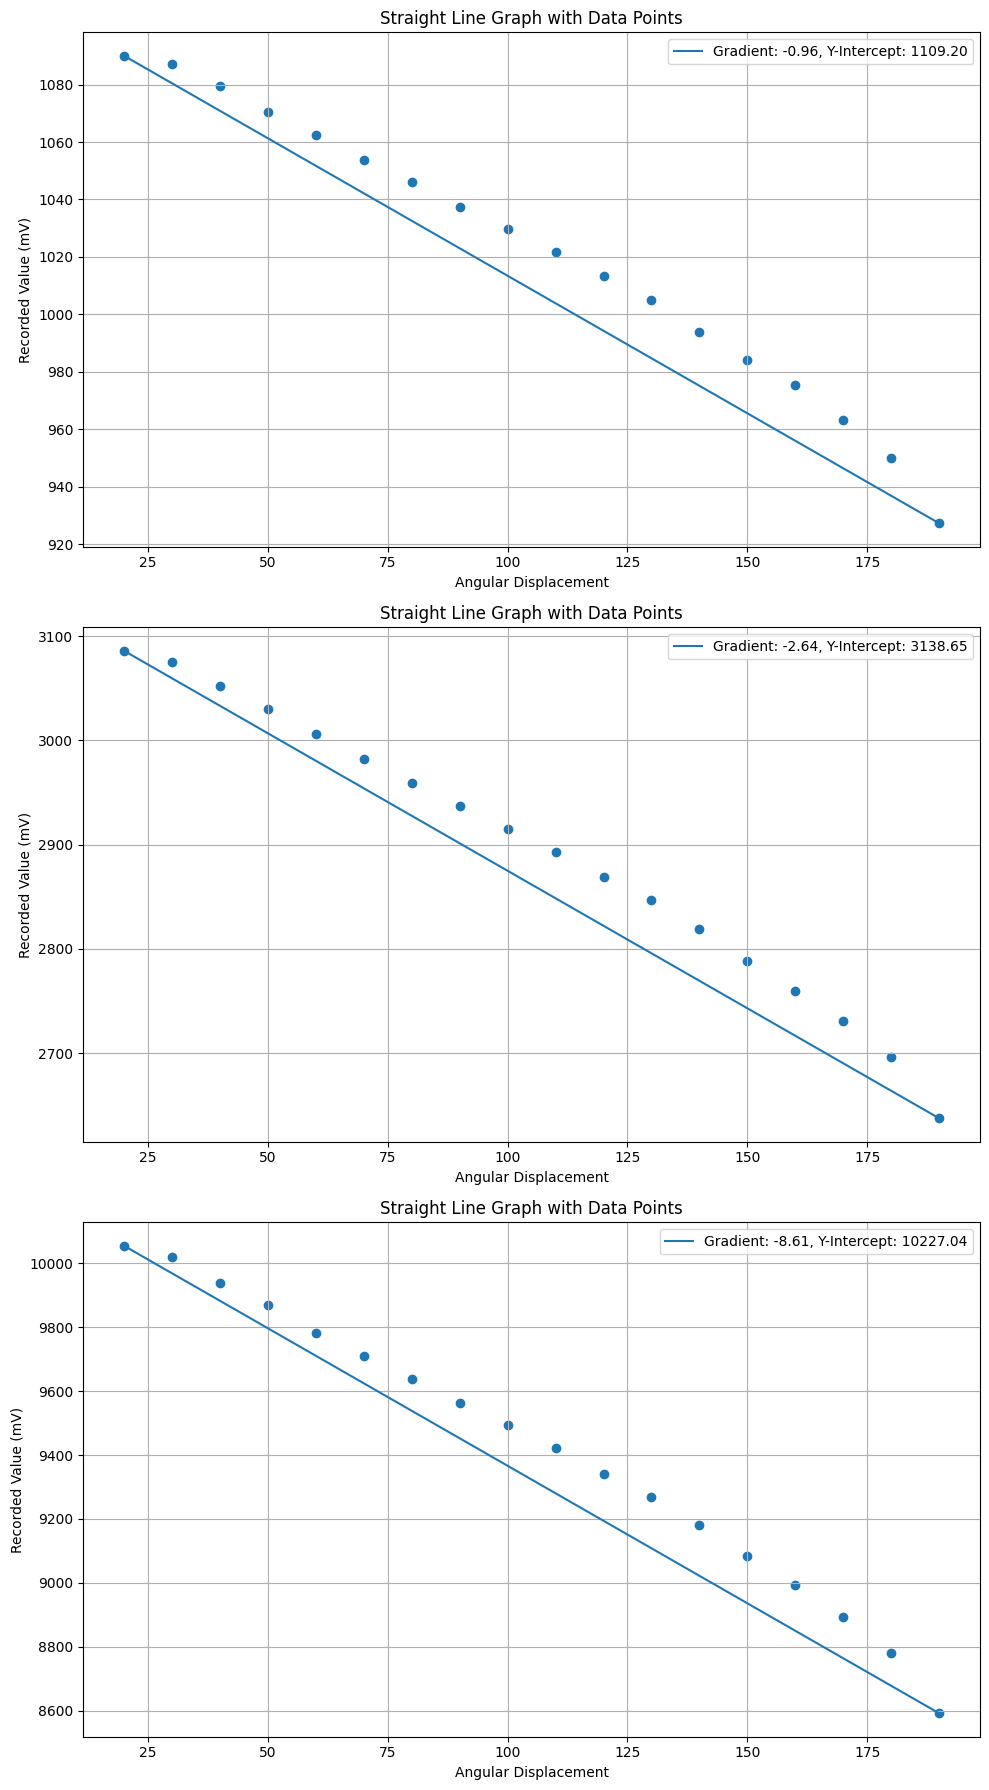

In [34]:
df_list = [pd.DataFrame.from_dict(df_v1), pd.DataFrame.from_dict(df_v3), pd.DataFrame.from_dict(df_v10)]

K_values = [
    (df["Recorded Value (V)"].iloc[-1] - df["Recorded Value (V)"].iloc[0]) /
    (df["Angular Displacement"].iloc[-1] - df["Angular Displacement"].iloc[0])
    for df in df_list
]

a_values = [
    df["Recorded Value (V)"].iloc[0] - result * df["Angular Displacement"].iloc[0]
    for df, result in zip(df_list, K_values)
]


# Plotting
# Create separate plots for each DataFrame
fig, axes = plt.subplots(len(df_list), 1, figsize=(10, 6 * len(df_list)))

for ax, df, m, c in zip(axes, df_list, K_values, a_values):
    x = df["Angular Displacement"]
    y = m * x + c
    ax.plot(x, y, label=f"Gradient: {m:.2f}, Y-Intercept: {c:.2f}")
    ax.scatter(df["Angular Displacement"], df["Recorded Value (V)"], marker='o')
    ax.set_title("Straight Line Graph with Data Points")
    ax.set_xlabel("Angular Displacement")
    ax.set_ylabel("Recorded Value (mV)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [41]:
# Calculating "Non linearity" and adding it as a new column to each DataFrame
for df, m, c in zip(df_list, K_values, a_values):
    straight_line_value = m * df["Angular Displacement"] + c
    df["Non linearity"] = df["Recorded Value (V)"] - straight_line_value
    max_recorded_value = df["Recorded Value (V)"].max()
    min_recorded_value = df["Recorded Value (V)"].min()
    df["Percentage Non linearity"] = (df["Non linearity"] / (max_recorded_value-min_recorded_value)) * 100

max_non_linearity = []
for df in df_list:
    max_non_linearity.append(df["Percentage Non linearity"].max())

for vol, i in zip([1,3,10], [0,1,2]):
    print(f"Max Non-linearity at {vol}V is {max_non_linearity[i]:.2f}%")

Max Non-linearity at 1V is 12.50%
Max Non-linearity at 3V is 11.34%
Max Non-linearity at 10V is 10.91%
